In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import catboost
from catboost import CatBoostClassifier, Pool
import yaml
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from functools import reduce

In [4]:
train = pd.read_csv('train_predobr.csv', sep=';')
train

,Gorod_PP_sokr,Город_ПП,ID,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города
0,Барнаул,Барнаул,72716,2015,41.0,Барнаул,средняя школа,Жен,ОО,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,0,64.410,один год,2,0,0.0,3,16019,1998,17.416667,6861
1,Барнаул,Барнаул,63306,2010,28.0,не указано,не указано,Муж,ЦН,нет данных,Россия,Алтайский край,0,Россия,0.0,0.0,1,67.000,нет данных об обучении до ВУЗа,4,1,1.0,4,14895,1992,18.250000,6861
2,Алтайское,Алтайское,82469,2017,41.0,Алтайский Край,средняя школа,Жен,ДН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,0,61.995,поступил сразу,3,1,1.0,4,20103,1999,18.333333,48
3,Барнаул,Барнаул,81661,2017,35.0,Барнаул,ФГБОУ ВО,Жен,БН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,74.000,поступил сразу,12,1,1.0,4,19838,1994,22.583333,6861
4,Барнаул,Барнаул,81509,2017,28.0,Барнаул,ФГБОУ ВО,Жен,БН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,53.000,поступил сразу,6,1,1.0,4,19803,1995,22.000000,6861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,Барнаул,Барнаул,74283,2016,34.0,Барнаул,средняя школа,Муж,ОО,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,59.000,поступил сразу,9,1,1.0,3,17593,1998,17.833333,6861
13580,Барнаул,Барнаул,71516,2015,26.0,Алтайский Край,средняя школа,Жен,ОО,Немецкий язык,Россия,Алтайский край,1,Россия,0.0,0.0,1,82.000,поступил сразу,9,0,0.0,4,19433,1997,17.833333,6861
13581,Барнаул,Барнаул,76970,2016,41.0,Барнаул,средняя школа,Муж,СН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,0,51.000,поступил сразу,3,1,1.0,4,18723,1998,18.333333,6861
13582,неизвестно,неизвестно,48548,2012,24.0,не указано,не указано,Жен,ОО,нет данных,Россия,не указано,0,Россия,0.0,0.0,1,95.000,нет данных об обучении до ВУЗа,7,1,1.0,4,14663,1995,17.000000,490


In [5]:
test = pd.read_csv('test_predobr.csv', sep=';')
test

,Gorod_PP_sokr,ID,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Город_ПП,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города
0,Барнаул,64996,2014,40.0,Барнаул,средняя школа,Барнаул,Жен,ДН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,49.0,поступил сразу,11,0,0.0,?,20608,1995,18.666667,3424
1,Барнаул,71837,2015,26.0,Алтайский Край,средняя школа,Барнаул,Жен,ДН,Немецкий язык,Россия,Алтайский край,0,Россия,1.0,0.0,1,77.0,один год,12,0,0.0,?,20613,1995,19.583333,3424
2,Барнаул,86587,2018,34.0,Барнаул,медицинское училище,Барнаул,Жен,ОО,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,74.0,свыше 10 лет,8,1,1.0,?,21210,1973,44.916667,3424
3,Барнаул,73673,2015,53.0,Барнаул,ФГБОУ ВО,Барнаул,Жен,ОО,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,57.0,от 5 до 10 лет,12,0,0.0,?,22254,1983,31.583333,3424
4,неизвестно,54709,2012,36.0,не указано,не указано,неизвестно,Жен,ОО,нет данных,не указана,не указано,0,Россия,0.0,0.0,1,55.0,нет данных об обучении до ВУЗа,5,1,1.0,?,15040,1994,18.166667,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,Павлодар,74342,2016,34.0,Казахстан,Лицей,Павлодар,Муж,БН,Английский язык,Казахстан,Павлодарская обл,1,Казахстан,0.0,1.0,1,77.0,от трех до пяти лет,3,1,1.0,?,20680,1992,24.333333,9
6687,малое поселение,54876,2013,36.0,не указано,не указано,Чемал,Жен,ОО,нет данных,Россия,Алтайский край,0,Россия,0.0,0.0,1,62.0,нет данных об обучении до ВУЗа,11,1,1.0,?,16921,1995,17.666667,1
6688,Барнаул,66879,2014,26.0,Барнаул,средняя школа,Барнаул,Жен,СН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,52.0,поступил сразу,3,0,0.0,?,19400,1996,18.250000,3424
6689,Ребриха,64982,2014,27.0,Алтайский Край,средняя школа,Ребриха,Муж,ОО,Немецкий язык,Россия,Алтайский край,1,Россия,1.0,0.0,1,69.0,поступил сразу,8,0,0.0,?,18152,1996,17.916667,26


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gorod_PP_sokr                     13584 non-null  object 
 1   Город_ПП                          13584 non-null  object 
 2   ID                                13584 non-null  int64  
 3   Год_Поступления                   13584 non-null  int64  
 4   КодФакультета                     13584 non-null  float64
 5   Город_УЗ                          13584 non-null  object 
 6   Тип_УЗ                            13584 non-null  object 
 7   Пол                               13577 non-null  object 
 8   Основания                         13584 non-null  object 
 9   Изучаемый_Язык                    13584 non-null  object 
 10  Страна_ПП                         13584 non-null  object 
 11  Регион_ПП                         13584 non-null  object 
 12  Обще

Text(0, 0.5, 'Counts')

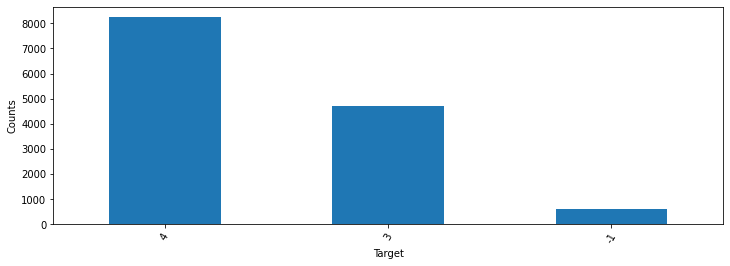

In [7]:
train['Статус'].value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Target",fontsize=10)
plt.ylabel("Counts",fontsize=10)

In [8]:
train['Статус'].value_counts()

 4    8249
 3    4721
-1     614
Name: Статус, dtype: int64

In [9]:
train.columns

Index(['Gorod_PP_sokr', 'Город_ПП', 'ID', 'Год_Поступления', 'КодФакультета',
       'Город_УЗ', 'Тип_УЗ', 'Пол', 'Основания', 'Изучаемый_Язык', 'Страна_ПП',
       'Регион_ПП', 'Общежитие', 'Страна_Родители', 'Село', 'Иностранец',
       'ЕГЭ', 'Общий балл', 'Тип паузы после УЗ', 'Месяц рождения',
       'Наличие_Матери', 'Наличие_Отца', 'Статус', 'Код_группы', 'God_GR',
       'Vozrast_to_VUS', 'Количество поступавших из города'],
      dtype='object')

In [10]:
column_names_to_train =['Год_Поступления',  'Город_УЗ', 'Тип_УЗ','КодФакультета',
        'Пол', 'Основания', 'Изучаемый_Язык', 'Город_ПП',
       'Страна_ПП', 'Регион_ПП', 'Общежитие', 'Страна_Родители', 
       'Иностранец', 'ЕГЭ', 'Тип паузы после УЗ','Общий балл', 
       'Месяц рождения',  'Наличие_Матери','God_GR',
       'Наличие_Отца','Код_группы','Vozrast_to_VUS', 'Количество поступавших из города']#,'Gorod_PP_sokr']

column_names_to_linear =['Общий балл']#,'Vozrast_to_VUS']

In [11]:
# для того, чтобы при создании категориальных переменных категории одинаковых групп в трейне и тесте совпадали, объединяем данные. 
# После категоризации - разъединяем (данные теста в трейне не используются)
train_all=pd.concat([train, test])
train_all

,Gorod_PP_sokr,Город_ПП,ID,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города
0,Барнаул,Барнаул,72716,2015,41.0,Барнаул,средняя школа,Жен,ОО,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,0,64.410,один год,2,0,0.0,3,16019,1998,17.416667,6861
1,Барнаул,Барнаул,63306,2010,28.0,не указано,не указано,Муж,ЦН,нет данных,Россия,Алтайский край,0,Россия,0.0,0.0,1,67.000,нет данных об обучении до ВУЗа,4,1,1.0,4,14895,1992,18.250000,6861
2,Алтайское,Алтайское,82469,2017,41.0,Алтайский Край,средняя школа,Жен,ДН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,0,61.995,поступил сразу,3,1,1.0,4,20103,1999,18.333333,48
3,Барнаул,Барнаул,81661,2017,35.0,Барнаул,ФГБОУ ВО,Жен,БН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,74.000,поступил сразу,12,1,1.0,4,19838,1994,22.583333,6861
4,Барнаул,Барнаул,81509,2017,28.0,Барнаул,ФГБОУ ВО,Жен,БН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,53.000,поступил сразу,6,1,1.0,4,19803,1995,22.000000,6861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,Павлодар,Павлодар,74342,2016,34.0,Казахстан,Лицей,Муж,БН,Английский язык,Казахстан,Павлодарская обл,1,Казахстан,0.0,1.0,1,77.000,от трех до пяти лет,3,1,1.0,?,20680,1992,24.333333,9
6687,малое поселение,Чемал,54876,2013,36.0,не указано,не указано,Жен,ОО,нет данных,Россия,Алтайский край,0,Россия,0.0,0.0,1,62.000,нет данных об обучении до ВУЗа,11,1,1.0,?,16921,1995,17.666667,1
6688,Барнаул,Барнаул,66879,2014,26.0,Барнаул,средняя школа,Жен,СН,Английский язык,Россия,Алтайский край,0,Россия,0.0,0.0,1,52.000,поступил сразу,3,0,0.0,?,19400,1996,18.250000,3424
6689,Ребриха,Ребриха,64982,2014,27.0,Алтайский Край,средняя школа,Муж,ОО,Немецкий язык,Россия,Алтайский край,1,Россия,1.0,0.0,1,69.000,поступил сразу,8,0,0.0,?,18152,1996,17.916667,26


In [12]:
# создание категориальных переменных
train_all['Год_Поступления']=train_all['Год_Поступления'].astype("category").cat.codes
train_all['КодФакультета']=train_all['КодФакультета'].astype("category").cat.codes
train_all['Город_УЗ']=train_all['Город_УЗ'].astype("category").cat.codes
train_all['Тип_УЗ']=train_all['Тип_УЗ'].astype("category").cat.codes
train_all['Город_ПП']=train_all['Город_ПП'].astype("category").cat.codes
train_all['Пол']=train_all['Пол'].astype("category").cat.codes
train_all['Основания']=train_all['Основания'].astype("category").cat.codes
train_all['Изучаемый_Язык']=train_all['Изучаемый_Язык'].astype("category").cat.codes
train_all['Страна_ПП']=train_all['Страна_ПП'].astype("category").cat.codes
train_all['Регион_ПП']=train_all['Регион_ПП'].astype("category").cat.codes
train_all['Общежитие']=train_all['Общежитие'].astype("category").cat.codes
train_all['Страна_Родители']=train_all['Страна_Родители'].astype("category").cat.codes
train_all['Село']=train_all['Село'].astype("category").cat.codes
train_all['Иностранец']=train_all['Иностранец'].astype("category").cat.codes
train_all['ЕГЭ']=train_all['ЕГЭ'].astype("category").cat.codes
train_all['Тип паузы после УЗ']=train_all['Тип паузы после УЗ'].astype("category").cat.codes
train_all['Месяц рождения']=train_all['Месяц рождения'].astype("category").cat.codes
train_all['Наличие_Матери']=train_all['Наличие_Матери'].astype("category").cat.codes
train_all['Наличие_Отца']=train_all['Наличие_Отца'].astype("category").cat.codes
train_all['Код_группы']=train_all['Код_группы'].astype("category").cat.codes
train_all['God_GR']=train_all['God_GR'].astype("category").cat.codes

train_all['Количество поступавших из города']=train_all['Количество поступавших из города'].astype("category").cat.codes
train_all['Gorod_PP_sokr']=train_all['Gorod_PP_sokr'].astype("category").cat.codes
# нормализация поля общего балла студента
train_all[column_names_to_linear]=np.log(1+train_all[column_names_to_linear])

In [13]:
# после категоризации - тест и трейн разделяем обратно
test=test[['ID']]
test_all = test.merge(train_all, how='left', on='ID')

In [14]:
train=train[['ID']]
train_all = train.merge(train_all, how='left', on='ID')

In [15]:
train_all

,ID,Gorod_PP_sokr,Город_ПП,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города
0,72716,8,69,13,12,1,11,0,3,1,9,1,0,11,0,0,0,4.180675,2,1,0,0,3,1144,47,17.416667,65
1,63306,8,69,8,4,15,10,1,5,8,9,1,0,11,0,0,1,4.219508,1,3,1,1,4,713,41,18.250000,65
2,82469,3,21,15,12,0,11,0,1,1,9,1,0,11,0,0,0,4.143055,5,2,1,1,4,2942,48,18.333333,40
3,81661,8,69,15,8,1,6,0,0,1,9,1,0,11,0,0,1,4.317488,5,11,1,1,4,2777,43,22.583333,65
4,81509,8,69,15,4,1,6,0,0,1,9,1,0,11,0,0,1,3.988984,5,5,1,1,4,2745,44,22.000000,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,74283,8,69,14,7,1,11,1,3,1,9,1,0,11,0,0,1,4.094345,5,8,1,1,3,1650,47,17.833333,65
13580,71516,8,69,13,2,0,11,0,3,5,9,1,1,11,0,0,1,4.418841,5,8,0,0,4,2549,46,17.833333,65
13581,76970,8,69,14,12,1,11,1,4,1,9,1,0,11,0,0,0,3.951244,5,2,1,1,4,2229,47,18.333333,65
13582,48548,162,1273,10,0,15,10,0,3,8,9,170,0,11,0,0,1,4.564348,1,6,1,1,4,620,44,17.000000,62


In [16]:
test_all

,ID,Gorod_PP_sokr,Город_ПП,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города
0,64996,8,69,12,11,1,11,0,1,1,9,1,0,11,0,0,1,3.912023,5,10,0,0,?,3129,44,18.666667,64
1,71837,8,69,13,2,0,11,0,1,5,9,1,0,11,1,0,1,4.356709,2,11,0,0,?,3134,44,19.583333,64
2,86587,8,69,16,7,1,9,0,3,1,9,1,0,11,0,0,1,4.317488,6,7,1,1,?,3522,22,44.916667,64
3,73673,8,69,13,19,1,6,0,3,1,9,1,0,11,0,0,1,4.060443,3,11,0,0,?,4090,32,31.583333,64
4,54709,162,1273,10,9,15,10,0,3,8,15,170,0,11,0,0,1,4.025352,1,4,1,1,?,755,43,18.166667,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,74342,98,739,14,7,5,3,1,0,1,4,75,1,3,0,1,1,4.356709,4,2,1,1,?,3194,41,24.333333,8
6687,54876,161,1174,11,9,15,10,0,3,8,9,1,0,11,0,0,1,4.143135,1,10,1,1,?,1278,44,17.666667,0
6688,66879,8,69,12,2,1,11,0,4,1,9,1,0,11,0,0,1,3.970292,5,2,0,0,?,2526,45,18.250000,64
6689,64982,109,836,12,3,0,11,1,3,5,9,1,1,11,1,0,1,4.248495,5,7,0,0,?,1873,45,17.916667,24


In [17]:
train_all['Статус']=train_all['Статус'].astype("category").cat.codes

In [18]:
train_all['Статус'].value_counts()

2    8249
1    4721
0     614
Name: Статус, dtype: int64

In [19]:
# Первое перемешивание - использовалось для создания и выбора сабмиссий в ансамбль, в показательном примере сабмиссии не используется 

#"train_all = train_all.sample(frac=1).reset_index(drop=True)

In [20]:
pool_train_solution = Pool(train_all[column_names_to_train], train_all['Статус'], cat_features = ['Год_Поступления',  'Город_УЗ', 'Тип_УЗ','КодФакультета',
        'Пол', 'Основания', 'Изучаемый_Язык', 'Город_ПП',
       'Страна_ПП', 'Регион_ПП', 'Общежитие', 'Страна_Родители', 
       'Иностранец', 'ЕГЭ', 'Тип паузы после УЗ',
       'Месяц рождения',  'Наличие_Матери','God_GR',
       'Наличие_Отца','Код_группы','Количество поступавших из города'])#,'Gorod_PP_sokr'])
pool_test_solution = Pool(train_all[column_names_to_train],cat_features = ['Год_Поступления',  'Город_УЗ', 'Тип_УЗ','КодФакультета',
        'Пол', 'Основания', 'Изучаемый_Язык', 'Город_ПП',
       'Страна_ПП', 'Регион_ПП', 'Общежитие', 'Страна_Родители', 
       'Иностранец', 'ЕГЭ', 'Тип паузы после УЗ',
       'Месяц рождения',  'Наличие_Матери','God_GR',
       'Наличие_Отца','Код_группы','Количество поступавших из города'])#,'Gorod_PP_sokr'])
                       
model_test = CatBoostClassifier(iterations=1000,  task_type='GPU',depth=12, verbose =True, random_seed=24,
                               leaf_estimation_method= 'Gradient',bootstrap_type= 'Bernoulli',objective = 'MultiClass',eval_metric = 'TotalF1')

model_test.fit(pool_train_solution)

0:	learn: 0.7874959	total: 372ms	remaining: 6m 11s
1:	learn: 0.7929773	total: 567ms	remaining: 4m 43s
2:	learn: 0.8379770	total: 845ms	remaining: 4m 40s
3:	learn: 0.8515535	total: 1.06s	remaining: 4m 24s
4:	learn: 0.8536165	total: 1.24s	remaining: 4m 6s
5:	learn: 0.8529697	total: 1.42s	remaining: 3m 54s
6:	learn: 0.8512784	total: 1.62s	remaining: 3m 49s
7:	learn: 0.8514281	total: 1.79s	remaining: 3m 42s
8:	learn: 0.8529816	total: 1.98s	remaining: 3m 37s
9:	learn: 0.8549990	total: 2.16s	remaining: 3m 33s
10:	learn: 0.8568926	total: 2.38s	remaining: 3m 34s
11:	learn: 0.8582633	total: 2.56s	remaining: 3m 31s
12:	learn: 0.8601514	total: 2.75s	remaining: 3m 28s
13:	learn: 0.8602187	total: 2.93s	remaining: 3m 26s
14:	learn: 0.8606058	total: 3.23s	remaining: 3m 31s
15:	learn: 0.8595520	total: 3.56s	remaining: 3m 39s
16:	learn: 0.8623156	total: 3.92s	remaining: 3m 46s
17:	learn: 0.8610774	total: 4.25s	remaining: 3m 52s
18:	learn: 0.8608400	total: 4.59s	remaining: 3m 56s
19:	learn: 0.8610098	to

In [21]:
# Проверка на трейне
predictions1 = model_test.predict(pool_test_solution)
train_all['Kategory_pred1']=predictions1
f1_score(train_all['Статус'], predictions1, average='macro', zero_division = 0)

0.842758651269567

In [22]:
train_all['Kategory_pred1'].value_counts()

2    8701
1    4574
0     309
Name: Kategory_pred1, dtype: int64

In [23]:
# проверка на тесте
predictions_test = model_test.predict(test_all[column_names_to_train])
test_all['Статус']=predictions_test
test_all['Статус'].value_counts()


2    4311
1    2356
0      24
Name: Статус, dtype: int64

In [24]:
# Возвращаем значения по тесту и трейну
train_all.loc[(train_all['Статус']==2),'Статус']=4
train_all.loc[(train_all['Статус']==1),'Статус']=3
train_all.loc[(train_all['Статус']==0),'Статус']=-1


test_all.loc[(test_all['Статус']==2),'Статус']=4
test_all.loc[(test_all['Статус']==1),'Статус']=3
test_all.loc[(test_all['Статус']==0),'Статус']=-1
test_all['Статус'].value_counts()

 4    4311
 3    2356
-1      24
Name: Статус, dtype: int64

In [25]:
# Предварительная сабмиссия для проверки
test_all_predv=test_all[['ID','Статус']]





In [26]:

test_all['Статус']=test_all_predv['Статус']

In [27]:
# Для определения -1 бинарным разделение сформируем дополнительное поле таргета и подвыборки
train_all['Kategory']=0
train_all.loc[(train_all['Статус']==-1),'Kategory']=1

In [28]:
train_all

,ID,Gorod_PP_sokr,Город_ПП,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города,Kategory_pred1,Kategory
0,72716,8,69,13,12,1,11,0,3,1,9,1,0,11,0,0,0,4.180675,2,1,0,0,3,1144,47,17.416667,65,1,0
1,63306,8,69,8,4,15,10,1,5,8,9,1,0,11,0,0,1,4.219508,1,3,1,1,4,713,41,18.250000,65,2,0
2,82469,3,21,15,12,0,11,0,1,1,9,1,0,11,0,0,0,4.143055,5,2,1,1,4,2942,48,18.333333,40,2,0
3,81661,8,69,15,8,1,6,0,0,1,9,1,0,11,0,0,1,4.317488,5,11,1,1,4,2777,43,22.583333,65,2,0
4,81509,8,69,15,4,1,6,0,0,1,9,1,0,11,0,0,1,3.988984,5,5,1,1,4,2745,44,22.000000,65,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,74283,8,69,14,7,1,11,1,3,1,9,1,0,11,0,0,1,4.094345,5,8,1,1,3,1650,47,17.833333,65,1,0
13580,71516,8,69,13,2,0,11,0,3,5,9,1,1,11,0,0,1,4.418841,5,8,0,0,4,2549,46,17.833333,65,2,0
13581,76970,8,69,14,12,1,11,1,4,1,9,1,0,11,0,0,0,3.951244,5,2,1,1,4,2229,47,18.333333,65,2,0
13582,48548,162,1273,10,0,15,10,0,3,8,9,170,0,11,0,0,1,4.564348,1,6,1,1,4,620,44,17.000000,62,2,0


In [29]:
train_all['Kategory']=train_all['Kategory'].astype(int)

In [30]:
# Второе перемешивание - в данном показательном примере сабмиссии также не используется

#train_all = train_all.sample(frac=1).reset_index(drop=True)

In [31]:
# Обучение бинарным по -1
xgb_estimator2 = xgb.XGBClassifier(
    learning_rate =0.01,
     n_estimators=145,
     max_depth=16,
     min_child_weight=6,
     gamma=0,
     verbosity=2,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:hinge',
     nthread=4,
     tree_method='approx',#,gpu_id=0, 
           #predictor='gpu_predictor',
    enable_categorical=True, 
    use_label_encoder=False,
     max_cat_to_onehot =1000,
     eval_metric='error',
     seed=45,
     feature_fraction=0.7,
        scale_pos_weight=50,)

In [32]:
%%time
# fit first model
xgb_estimator2.fit(train_all[column_names_to_train], train_all['Kategory'])

[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=12
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=14
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=14
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=13
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=12
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=14
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=14
[10:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

XGBClassifier(colsample_bytree=0.8, enable_categorical=True,
              eval_metric='error', feature_fraction=0.7, learning_rate=0.01,
              max_cat_to_onehot=1000, max_depth=16, min_child_weight=6,
              n_estimators=145, nthread=4, objective='binary:hinge',
              scale_pos_weight=50, seed=45, subsample=0.8, tree_method='approx',
              use_label_encoder=False, verbosity=2)

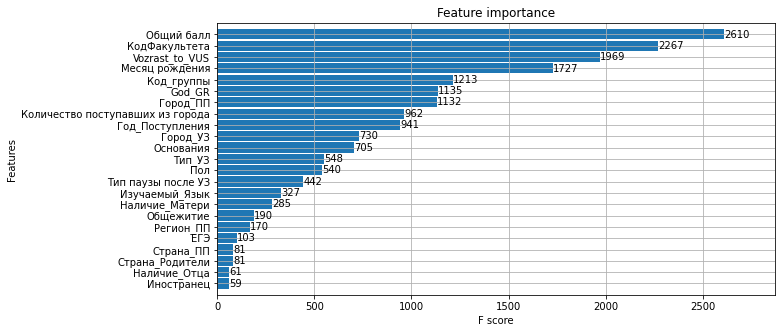

In [33]:
# Важность признаков XGBoost
# Обратим внимание, что для -1 наиболее важный признак - баллы обучения
_ = plot_importance(xgb_estimator2, height=0.9)

In [34]:
# Проверка на трейне
predictions2 = xgb_estimator2.predict(train_all[column_names_to_train])
train_all['Kategory_pred1']=predictions2
f1_score(train_all['Kategory'], predictions2, average='macro', zero_division = 0)

0.8827912910461748

In [35]:
# проверка на тесте
predictions_fin= xgb_estimator2.predict(test_all[column_names_to_train])
test_all['Kategory_pred1']=predictions_fin
test_all['Kategory_pred1'].value_counts()

0    6382
1     309
Name: Kategory_pred1, dtype: int64

In [36]:
# Переносим значения -1 в статус и формируем сабмиссию
test_all.loc[(test_all['Kategory_pred1']==1),'Статус']=-1
test_all

,ID,Gorod_PP_sokr,Город_ПП,Год_Поступления,КодФакультета,Город_УЗ,Тип_УЗ,Пол,Основания,Изучаемый_Язык,Страна_ПП,Регион_ПП,Общежитие,Страна_Родители,Село,Иностранец,ЕГЭ,Общий балл,Тип паузы после УЗ,Месяц рождения,Наличие_Матери,Наличие_Отца,Статус,Код_группы,God_GR,Vozrast_to_VUS,Количество поступавших из города,Kategory_pred1
0,64996,8,69,12,11,1,11,0,1,1,9,1,0,11,0,0,1,3.912023,5,10,0,0,4,3129,44,18.666667,64,0
1,71837,8,69,13,2,0,11,0,1,5,9,1,0,11,1,0,1,4.356709,2,11,0,0,4,3134,44,19.583333,64,0
2,86587,8,69,16,7,1,9,0,3,1,9,1,0,11,0,0,1,4.317488,6,7,1,1,4,3522,22,44.916667,64,0
3,73673,8,69,13,19,1,6,0,3,1,9,1,0,11,0,0,1,4.060443,3,11,0,0,3,4090,32,31.583333,64,0
4,54709,162,1273,10,9,15,10,0,3,8,15,170,0,11,0,0,1,4.025352,1,4,1,1,4,755,43,18.166667,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,74342,98,739,14,7,5,3,1,0,1,4,75,1,3,0,1,1,4.356709,4,2,1,1,4,3194,41,24.333333,8,0
6687,54876,161,1174,11,9,15,10,0,3,8,9,1,0,11,0,0,1,4.143135,1,10,1,1,4,1278,44,17.666667,0,0
6688,66879,8,69,12,2,1,11,0,4,1,9,1,0,11,0,0,1,3.970292,5,2,0,0,4,2526,45,18.250000,64,0
6689,64982,109,836,12,3,0,11,1,3,5,9,1,1,11,1,0,1,4.248495,5,7,0,0,4,1873,45,17.916667,24,0


In [37]:
# Проверяем поле статуса
test_all['Статус'].value_counts()

 4    4309
 3    2067
-1     315
Name: Статус, dtype: int64

In [38]:
test_unit=test_all[['ID','Статус']]
test_unit

,ID,Статус
0,64996,4
1,71837,4
2,86587,4
3,73673,3
4,54709,4
...,...,...
6686,74342,4
6687,54876,4
6688,66879,4
6689,64982,4


In [39]:
test_unit.to_csv('submission_13.csv', index=False, sep=',', encoding='utf-8')